In [72]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
from drawinganalyses.datasets.drawing_collection import DrawingCollection
from drawinganalyses.config import (
    LOCAL_DATA_DIR,
    DATASET_NAME,
    MODELS_STORAGE,
    ANNOTATION_FILE,
    MODEL_NAME,
    label_to_str
)
cudnn.benchmark = True
plt.ion()   # interactive mode

In [73]:
drawing_collection = DrawingCollection(LOCAL_DATA_DIR / DATASET_NAME)
images = drawing_collection.get_images()
labels = drawing_collection.get_labels()

1it [00:00, 1142.86it/s]


In [74]:
images

[]

In [43]:
images = np.array(images)

In [44]:
map_chan = {0:'r', 1:'g', 2:'b'}
chan = {}
for i in range(images.shape[-1]):
    chan[map_chan[i]] = images[:,:,:,i]

for channel, values in chan.items():
    print('channel :', channel)
    print('mean :', np.mean(values))
    print('std :', np.std(values))
    print('max :', values.max())
    print('min :', values.min())


channel : r
mean : 226.33071565306645
std : 26.743486107824683
max : 255
min : 8
channel : g
mean : 215.4811843041656
std : 30.963353911014543
max : 255
min : 9
channel : b
mean : 206.45583449662132
std : 40.62421935567317
max : 255
min : 8


In [45]:
X_train, X_test = np.array(images[0:1000]), np.array(images[1000:])
Y_train, Y_test = np.array(labels[0:1000]), np.array(labels[1000:])

In [46]:
from drawinganalyses.utils.utils import feature_extraction

In [47]:
# Extracting train features

import numpy as np
total = np.empty((len(X_train), 3, 44))
for idx, image in enumerate(X_train):
    feat, labels_feat = feature_extraction(image)
    total[idx] = feat

In [48]:
total.shape

(1000, 3, 44)

In [49]:
features_train = total.reshape(total.shape[0], -1)

In [50]:
# Extracting test features

total_test = np.empty((len(X_test), 3, 44))
for idx, image in enumerate(X_test):
    feat, labels_feat = feature_extraction(image)
    total_test[idx] = feat

In [51]:
feature_test =  total_test.reshape(total_test.shape[0], -1)

In [52]:
import xgboost as xgb

In [53]:
# Renaming features to ensure we can differentiate between channels

chans = ['r', 'g', 'b']
labels_name = []
for chan in chans:
    for idx, label_feat in enumerate(labels_feat):
        labels_name.append(f"{chan}_{label_feat}")

In [54]:
eval_set = [(features_train, Y_train), (feature_test, Y_test)]
len(eval_set)

2

In [37]:
feature_test.shape

(299, 132)

In [38]:
Y_test.shape

(299, 1)

In [56]:
model = xgb.XGBClassifier()
model.fit(features_train, Y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
model.get_booster().feature_names = labels_name

[0]	validation_0-merror:0.69200	validation_0-mlogloss:1.37525	validation_1-merror:0.72575	validation_1-mlogloss:1.37459
[1]	validation_0-merror:0.67600	validation_0-mlogloss:1.36897	validation_1-merror:0.72575	validation_1-mlogloss:1.38398
[2]	validation_0-merror:0.65500	validation_0-mlogloss:1.39792	validation_1-merror:0.72910	validation_1-mlogloss:1.37065
[3]	validation_0-merror:0.66100	validation_0-mlogloss:1.39481	validation_1-merror:0.71572	validation_1-mlogloss:2.13036
[4]	validation_0-merror:0.66600	validation_0-mlogloss:1.65175	validation_1-merror:0.74247	validation_1-mlogloss:3.07278


[5]	validation_0-merror:0.66200	validation_0-mlogloss:1.64081	validation_1-merror:0.73913	validation_1-mlogloss:3.06691
[6]	validation_0-merror:0.65700	validation_0-mlogloss:1.62303	validation_1-merror:0.72910	validation_1-mlogloss:3.05291
[7]	validation_0-merror:0.65500	validation_0-mlogloss:1.60622	validation_1-merror:0.74247	validation_1-mlogloss:3.05753
[8]	validation_0-merror:0.66000	validation_0-mlogloss:1.60608	validation_1-merror:0.72910	validation_1-mlogloss:3.05170
[9]	validation_0-merror:0.66200	validation_0-mlogloss:1.66336	validation_1-merror:0.72241	validation_1-mlogloss:3.87760
[10]	validation_0-merror:0.66300	validation_0-mlogloss:1.65169	validation_1-merror:0.71906	validation_1-mlogloss:3.86884
[11]	validation_0-merror:0.65800	validation_0-mlogloss:1.64012	validation_1-merror:0.71572	validation_1-mlogloss:3.87291
[12]	validation_0-merror:0.65400	validation_0-mlogloss:1.62796	validation_1-merror:0.71572	validation_1-mlogloss:3.87800
[13]	validation_0-merror:0.65500	vali

In [57]:
prediction = model.predict(feature_test)

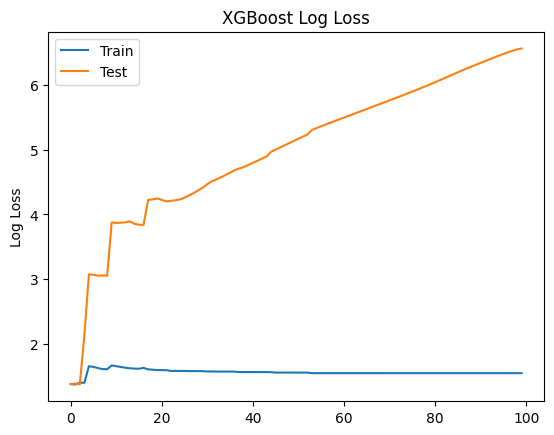

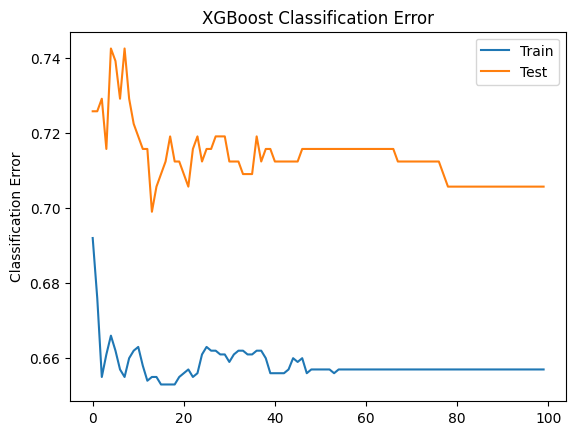

In [60]:
from matplotlib import pyplot

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [61]:
from sklearn import metrics

In [62]:
print('Accuracy = ', metrics.accuracy_score(Y_test, prediction))

Accuracy =  0.29431438127090304


In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
def convert_array_with_mapping(arr, mapping_dict):
    # Utilisez la fonction vectorisée np.vectorize pour appliquer la conversion à chaque élément du tableau
    convert_func = np.vectorize(lambda x: mapping_dict.get(x, str(x)))
    converted_arr = convert_func(arr)
    return converted_arr

In [65]:
result_array = convert_array_with_mapping(prediction, label_to_str)
label_test = convert_array_with_mapping(Y_test, label_to_str)

In [66]:
cm = confusion_matrix(label_test, result_array)

<Axes: >

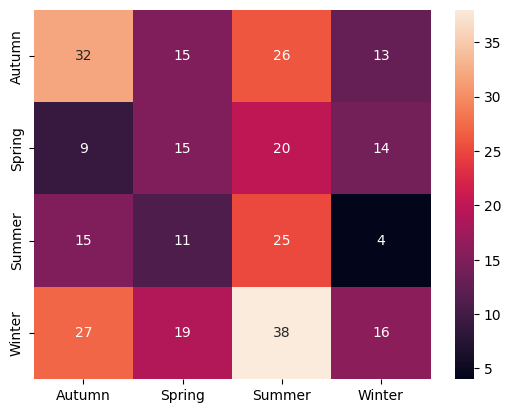

In [67]:
import seaborn as sns

sns.heatmap(cm, annot=True, xticklabels=label_to_str.values(), yticklabels= label_to_str.values())

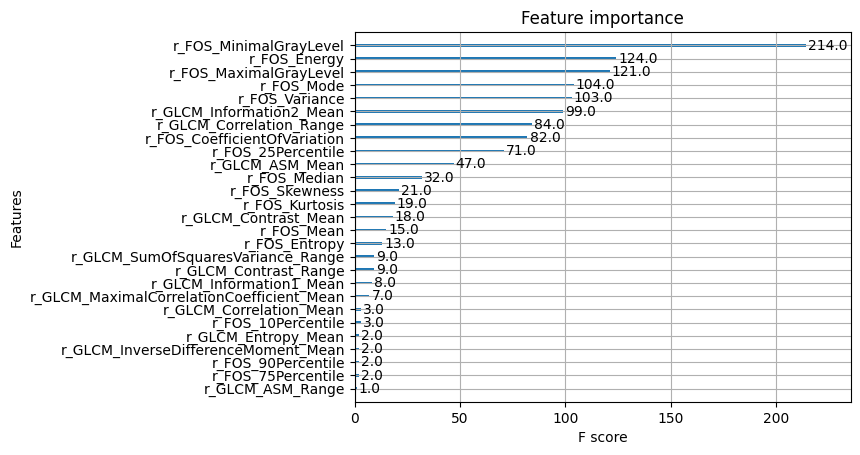

In [68]:
# plot feature importance

from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model)
pyplot.show()

In [69]:
model.get_booster().get_score()

{'r_FOS_Mean': 15.0,
 'r_FOS_Variance': 103.0,
 'r_FOS_Median': 32.0,
 'r_FOS_Mode': 104.0,
 'r_FOS_Skewness': 21.0,
 'r_FOS_Kurtosis': 19.0,
 'r_FOS_Energy': 124.0,
 'r_FOS_Entropy': 13.0,
 'r_FOS_MinimalGrayLevel': 214.0,
 'r_FOS_MaximalGrayLevel': 121.0,
 'r_FOS_CoefficientOfVariation': 82.0,
 'r_FOS_10Percentile': 3.0,
 'r_FOS_25Percentile': 71.0,
 'r_FOS_75Percentile': 2.0,
 'r_FOS_90Percentile': 2.0,
 'r_GLCM_ASM_Mean': 47.0,
 'r_GLCM_Contrast_Mean': 18.0,
 'r_GLCM_Correlation_Mean': 3.0,
 'r_GLCM_InverseDifferenceMoment_Mean': 2.0,
 'r_GLCM_Entropy_Mean': 2.0,
 'r_GLCM_Information1_Mean': 8.0,
 'r_GLCM_Information2_Mean': 99.0,
 'r_GLCM_MaximalCorrelationCoefficient_Mean': 7.0,
 'r_GLCM_ASM_Range': 1.0,
 'r_GLCM_Contrast_Range': 9.0,
 'r_GLCM_Correlation_Range': 84.0,
 'r_GLCM_SumOfSquaresVariance_Range': 9.0}